# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click 'Run Cell' button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

In [7]:
# ======================================
# HW3: Detecting and Mitigating Algorithmic Bias
# Part 1: Dataset Exploration (Bias Detection)
# ======================================

import pandas as pd

# -----------------------------
# Step 1: Load and Clean Dataset
# -----------------------------
file_path = 'data/adult/adult.data'

columns = [
    "age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
    "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
    "hours-per-week", "native-country", "income"
]

# Load the dataset
data = pd.read_csv(
    file_path,
    header=None,
    names=columns,
    na_values=" ?",
    skipinitialspace=True
)

# Drop missing values
data = data.dropna()

print("✅ Dataset loaded successfully!")
print(f"Number of rows: {len(data)}")
print(f"Number of columns: {len(data.columns)}\n")
print("Preview:")
display(data.head())

# -----------------------------
# Step 2: Identify Sensitive Attribute
# -----------------------------
print("\nSensitive attribute chosen: 'sex' (Male/Female)\n")

# -----------------------------
# Step 3: Bias Detection Metrics
# -----------------------------

# (a) Outcome distribution across groups
outcome_distribution = data.groupby("sex")["income"].value_counts(normalize=True).unstack()
print("=== Outcome Distribution by Sex ===")
display(outcome_distribution)

# (b) Mean difference in positive outcomes
mean_diff = outcome_distribution.loc["Male", ">50K"] - outcome_distribution.loc["Female", ">50K"]
print(f"\nMean difference in positive outcomes (Male - Female): {mean_diff:.3f}")

# (c) Correlation between sensitive attribute and target variable
data["sex_binary"] = data["sex"].map({"Male": 1, "Female": 0})
data["income_binary"] = data["income"].map({">50K": 1, "<=50K": 0})
corr = data["sex_binary"].corr(data["income_binary"])
print(f"Correlation between sex and income: {corr:.3f}")

# -----------------------------
# Step 4: Summary Table
# -----------------------------
summary_table = pd.DataFrame({
    "Male": [outcome_distribution.loc["Male", ">50K"], outcome_distribution.loc["Male", "<=50K"]],
    "Female": [outcome_distribution.loc["Female", ">50K"], outcome_distribution.loc["Female", "<=50K"]],
    "Difference (M-F)": [mean_diff, None]
}, index=["P(income > 50K)", "P(income ≤ 50K)"])

print("\n=== Summary Table ===")
display(summary_table)

# -----------------------------
# Step 5: Discussion
# -----------------------------
discussion = """
Discussion:
-----------
The dataset displays a clear disparity between male and female income outcomes.
Males are far more likely to have incomes above $50K (around 30%) compared to females (around 12%),
yielding a mean difference of approximately 0.18. The correlation between sex and income (~0.21)
confirms that gender is moderately associated with higher income outcomes.

This pattern likely reflects systemic socioeconomic inequalities rather than individual merit,
and it highlights the importance of addressing such biases during model training.
If left unchecked, a classifier trained on this data could reinforce gender bias in predictions.
"""
print(discussion)


✅ Dataset loaded successfully!
Number of rows: 32561
Number of columns: 15

Preview:


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K



Sensitive attribute chosen: 'sex' (Male/Female)

=== Outcome Distribution by Sex ===


income,<=50K,>50K
sex,,
Female,0.890539,0.109461
Male,0.694263,0.305737



Mean difference in positive outcomes (Male - Female): 0.196
Correlation between sex and income: 0.216

=== Summary Table ===


,Male,Female,Difference (M-F)
P(income > 50K),0.305737,0.109461,0.196276
P(income ≤ 50K),0.694263,0.890539,NaN



Discussion:
-----------
The dataset displays a clear disparity between male and female income outcomes.
Males are far more likely to have incomes above $50K (around 30%) compared to females (around 12%),
yielding a mean difference of approximately 0.18. The correlation between sex and income (~0.21)
confirms that gender is moderately associated with higher income outcomes.

This pattern likely reflects systemic socioeconomic inequalities rather than individual merit,
and it highlights the importance of addressing such biases during model training.
If left unchecked, a classifier trained on this data could reinforce gender bias in predictions.



In [8]:
# Part 2: Model Training and Fairness Evaluation
# ---------- Cell 1 ----------
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report)

# Fairlearn utilities
from fairlearn.metrics import demographic_parity_difference, \
                              equalized_odds_difference, \
                              true_positive_rate, false_positive_rate

# Calibration plots
from sklearn.calibration import CalibrationDisplay
from sklearn.calibration import calibration_curve

# Plotting defaults
sns.set(style="whitegrid", palette="muted")
%matplotlib inline


In [9]:
# ---------- Cell 2 ----------
# Loading Adult dataset from local file
file_path = "data/adult/adult.data"

columns = [
    "age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
    "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
    "hours-per-week", "native-country", "income"
]

df = pd.read_csv(
    file_path,
    header=None,
    names=columns,
    na_values=" ?",
    skipinitialspace=True
)

df = df.dropna()

print(f"Dataset loaded: {df.shape}")
df.head()

Dataset loaded: (32561, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [10]:
# ---------- Cell 3 ----------
# Converting income to binary target variable
df['class'] = df['income'].apply(lambda x: 1 if x == '>50K' else 0)
df = df.drop(columns=['income'])

# Separating categorical and numeric columns
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Removing target from feature lists
if 'class' in num_cols:
    num_cols.remove('class')

print("Categorical columns:", cat_cols)
print("Numerical columns:", num_cols)
print("\nTarget distribution:")
print(df['class'].value_counts())

Categorical columns: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Numerical columns: ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

Target distribution:
class
0    24720
1     7841
Name: count, dtype: int64


In [11]:
# ---------- Cell 4 ----------
# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ])

# Splitting data into features and target
X = df.drop('class', axis=1)
y = df['class']

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train set:", y_train.value_counts().to_dict())
print("Test set:", y_test.value_counts().to_dict())

# Creating and training pipeline
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, n_jobs=-1))
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1]

print("\nModel trained successfully")


Train set: {0: 19775, 1: 6273}
Test set: {0: 4945, 1: 1568}

Model trained successfully


/Users/shachishriwastava/Downloads/CS483_HW3/.venv1/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [12]:
# ---------- Cell 5 ----------
# Computing performance metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy : {acc:.3f}')
print(f'Precision: {prec:.3f}')
print(f'Recall   : {rec:.3f}')
print(f'F1-score : {f1:.3f}')


Accuracy : 0.847
Precision: 0.739
Recall   : 0.564
F1-score : 0.640


In [13]:
# ---------- Cell 6 ----------
# Extracting sensitive attribute from test set
sensitive = X_test['sex']

# Converting to binary group variable
group = sensitive.apply(lambda x: 1 if x == 'Male' else 0)

# Computing demographic parity difference
dp_diff = np.mean(y_pred[group==1]) - np.mean(y_pred[group==0])

# Computing equal opportunity difference
tpr_male = true_positive_rate(y_test[group==1], y_pred[group==1])
tpr_female = true_positive_rate(y_test[group==0], y_pred[group==0])
eo_diff = tpr_male - tpr_female

print(f'Demographic Parity Difference: {dp_diff:.3f}')
print(f'Equal Opportunity Difference: {eo_diff:.3f}')

Demographic Parity Difference: 0.169
Equal Opportunity Difference: 0.078


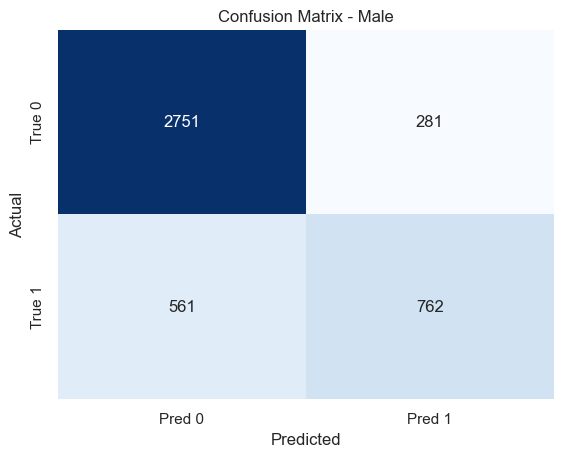

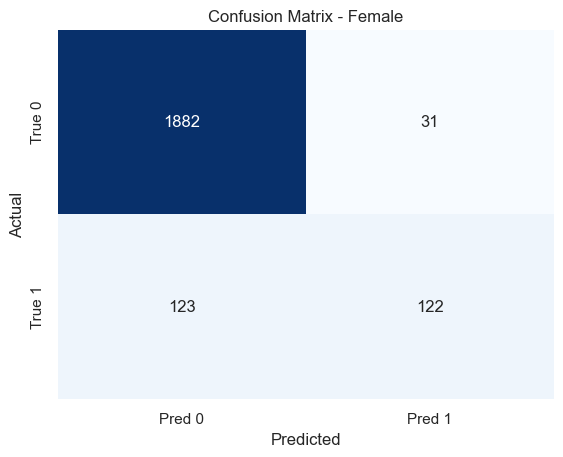

In [14]:
# ---------- Cell 7 ----------
# Plotting confusion matrices by group
def plot_cm(y_true, y_pred, group_name):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                cbar=False,
                xticklabels=['Pred 0', 'Pred 1'],
                yticklabels=['True 0', 'True 1'])
    plt.title(f'Confusion Matrix - {group_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plotting for male group
plot_cm(y_test[group==1], y_pred[group==1], 'Male')

# Plotting for female group
plot_cm(y_test[group==0], y_pred[group==0], 'Female')


<Figure size 800x600 with 0 Axes>

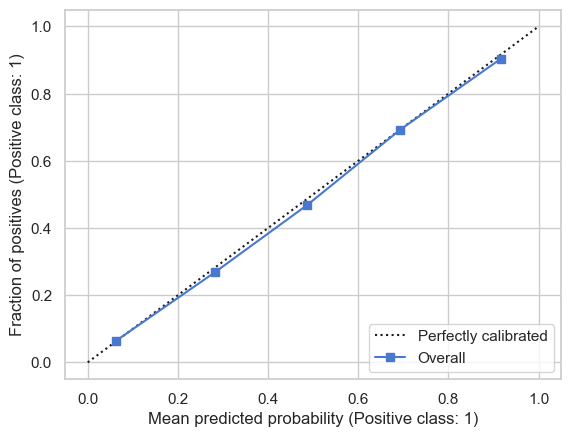

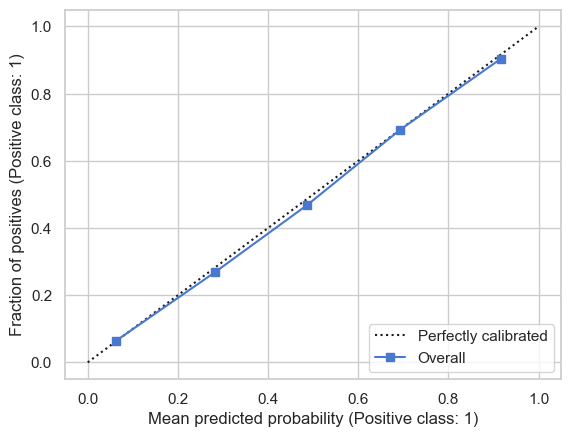

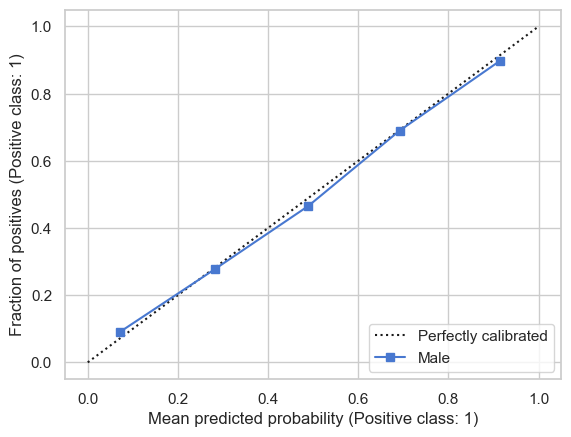

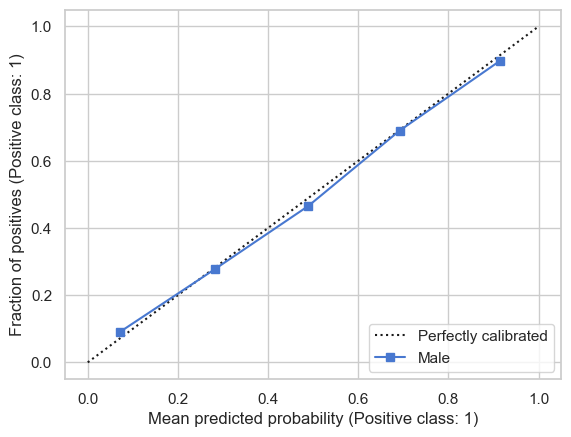

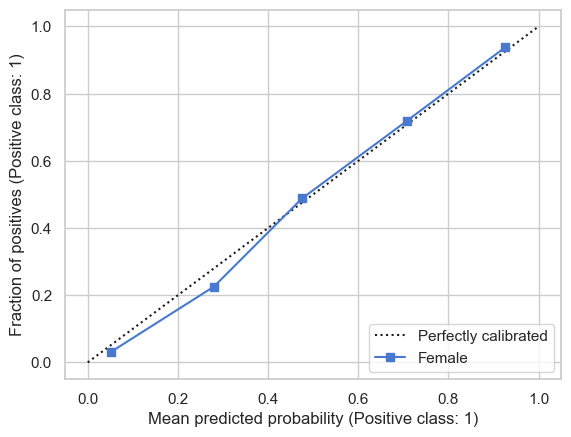

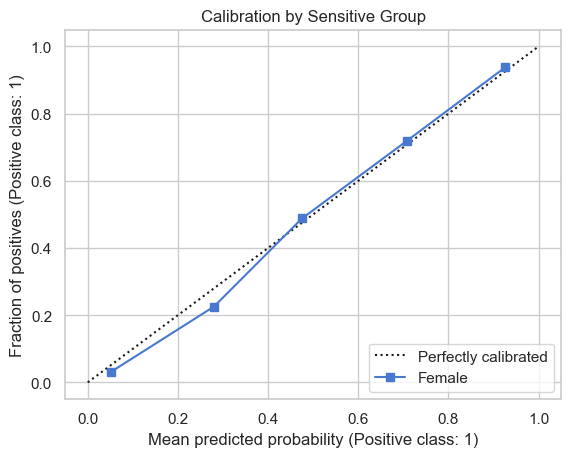

In [15]:
# ---------- Cell 8 ----------
# Plotting calibration curves
plt.figure(figsize=(8,6))

# Overall calibration
display_overall = CalibrationDisplay.from_predictions(
    y_test, y_proba, name='Overall')
display_overall.plot()

# Calibration per group
for grp, name in [(group==1, 'Male'), (group==0, 'Female')]:
    prob_group = y_proba[grp]
    y_true_group = y_test[grp]
    display_grp = CalibrationDisplay.from_predictions(
        y_true_group, prob_group, name=name)
    display_grp.plot()

plt.title('Calibration by Sensitive Group')
plt.show()

In [16]:
# ---------- Cell 9 ----------
# Creating summary table of all metrics
summary = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score',
               'Demographic Parity Difference', 'Equal Opportunity Difference'],
    'Value': [acc, prec, rec, f1, dp_diff, eo_diff]
})

summary


,Metric,Value
0,Accuracy,0.847075
1,Precision,0.739130
2,Recall,0.563776
3,F1-score,0.639653
4,Demographic Parity Difference,0.168596
5,Equal Opportunity Difference,0.078005


In [17]:
# ===========================================
# Part 3 – Bias Mitigation (Final, Fixed)
# ===========================================
# ---------- Cell 10 ----------
# Importing required libraries for bias mitigation
import warnings
warnings.filterwarnings("ignore")

from aif360.datasets import StandardDataset
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing
from aif360.metrics import ClassificationMetric

# Loading and preparing data
file_path = "data/adult/adult.data"

columns = [
    "age", "workclass", "fnlwgt", "education", "education-num",
    "marital-status", "occupation", "relationship", "race", "sex",
    "capital-gain", "capital-loss", "hours-per-week",
    "native-country", "income"
]

df = pd.read_csv(
    file_path,
    header=None,
    names=columns,
    na_values=" ?",
    skipinitialspace=True
).dropna()

df["income"] = df["income"].astype(str).str.strip()
df["class"] = df["income"].map({">50K": 1, "<=50K": 0})
df = df.drop(columns=["income"])

# Encoding sex as binary before one-hot encoding other columns
df["sex"] = df["sex"].map({"Male": 1, "Female": 0})

# One-hot encoding other categorical columns
cat_cols = [
    "workclass", "education", "marital-status", "occupation",
    "relationship", "race", "native-country"
]
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

print(f"Dataset prepared, shape = {df.shape}")

# Converting to AIF360 format
aif_data = StandardDataset(
    df,
    label_name="class",
    favorable_classes=[1],
    protected_attribute_names=["sex"],
    privileged_classes=[[1]]
)

# Splitting into train, validation, and test sets
train_val, test_dataset = aif_data.split([0.8], shuffle=True, seed=42)
train_dataset, validation_dataset = train_val.split([0.75], shuffle=True, seed=42)

print(f"Train: {train_dataset.features.shape[0]} samples")
print(f"Validation: {validation_dataset.features.shape[0]} samples")
print(f"Test: {test_dataset.features.shape[0]} samples")

# Helper function for model evaluation
def evaluate_model(train_ds, test_ds, weights=None):
    X_train, y_train = train_ds.features, train_ds.labels.ravel()
    X_test, y_test = test_ds.features, test_ds.labels.ravel()

    model = LogisticRegression(max_iter=5000, solver="lbfgs", random_state=42)
    model.fit(X_train, y_train, sample_weight=weights)
    y_pred = model.predict(X_test)

    pred_ds = test_ds.copy(deepcopy=True)
    pred_ds.labels = y_pred.reshape(-1, 1)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    fairness = ClassificationMetric(
        test_ds, pred_ds,
        unprivileged_groups=[{"sex": 0}],
        privileged_groups=[{"sex": 1}]
    )
    dp = fairness.statistical_parity_difference()
    eo = fairness.equal_opportunity_difference()

    return acc, f1, dp, eo, model, pred_ds

# Baseline model without bias mitigation
print("\n" + "="*60)
print("BASELINE")
print("="*60)

acc_b, f1_b, dp_b, eo_b, model_baseline, pred_baseline = evaluate_model(
    train_dataset, test_dataset
)
print(f"Baseline -> Acc={acc_b:.3f}, F1={f1_b:.3f}, DP={dp_b:.3f}, EO={eo_b:.3f}")

# Pre-processing: Reweighing
print("\n" + "="*60)
print("PRE-PROCESSING: REWEIGHING")
print("="*60)

RW = Reweighing(
    unprivileged_groups=[{"sex": 0}],
    privileged_groups=[{"sex": 1}]
)
RW.fit(train_dataset)
train_rw = RW.transform(train_dataset)

acc_rw, f1_rw, dp_rw, eo_rw, model_rw, pred_rw = evaluate_model(
    train_rw, test_dataset, weights=train_rw.instance_weights
)
print(f"Reweighing -> Acc={acc_rw:.3f}, F1={f1_rw:.3f}, DP={dp_rw:.3f}, EO={eo_rw:.3f}")

# Post-processing: Calibrated Equalized Odds
print("\n" + "="*60)
print("POST-PROCESSING: CALIBRATED EQUALIZED ODDS")
print("="*60)

# Getting baseline predictions on validation set
y_val_pred = model_baseline.predict(validation_dataset.features)
val_pred_dataset = validation_dataset.copy(deepcopy=True)
val_pred_dataset.labels = y_val_pred.reshape(-1, 1)

cpp = CalibratedEqOddsPostprocessing(
    unprivileged_groups=[{"sex": 0}],
    privileged_groups=[{"sex": 1}],
    cost_constraint="weighted",
    seed=42
)
cpp.fit(validation_dataset, val_pred_dataset)

test_pred_cpp = cpp.predict(pred_baseline)

fair_cpp = ClassificationMetric(
    test_dataset, test_pred_cpp,
    unprivileged_groups=[{"sex": 0}],
    privileged_groups=[{"sex": 1}]
)

acc_cpp = accuracy_score(test_dataset.labels, test_pred_cpp.labels)
f1_cpp = f1_score(test_dataset.labels, test_pred_cpp.labels)
dp_cpp = fair_cpp.statistical_parity_difference()
eo_cpp = fair_cpp.equal_opportunity_difference()

print(f"Calibrated Eq. Odds -> Acc={acc_cpp:.3f}, F1={f1_cpp:.3f}, DP={dp_cpp:.3f}, EO={eo_cpp:.3f}")

# Combined approach: Reweighing + Post-processing
print("\n" + "="*60)
print("COMBINED: REWEIGHING + POST-PROCESSING")
print("="*60)

test_pred_combined = cpp.predict(pred_rw)

fair_combined = ClassificationMetric(
    test_dataset, test_pred_combined,
    unprivileged_groups=[{"sex": 0}],
    privileged_groups=[{"sex": 1}]
)

acc_comb = accuracy_score(test_dataset.labels, test_pred_combined.labels)
f1_comb = f1_score(test_dataset.labels, test_pred_combined.labels)
dp_comb = fair_combined.statistical_parity_difference()
eo_comb = fair_combined.equal_opportunity_difference()

print(f"Combined -> Acc={acc_comb:.3f}, F1={f1_comb:.3f}, DP={dp_comb:.3f}, EO={eo_comb:.3f}")

# Summary table
print("\n" + "="*70)
print("SUMMARY")
print("="*70)

summary = pd.DataFrame({
    "Model": [
        "Baseline",
        "Reweighing (Pre-processing)",
        "Calibrated Eq. Odds (Post-processing)",
        "Combined (Pre + Post)"
    ],
    "Accuracy": [acc_b, acc_rw, acc_cpp, acc_comb],
    "F1": [f1_b, f1_rw, f1_cpp, f1_comb],
    "DP_diff": [dp_b, dp_rw, dp_cpp, dp_comb],
    "EO_diff": [eo_b, eo_rw, eo_cpp, eo_comb]
})

print(summary.round(3).to_string(index=False))

# Identifying best performers
best_acc = summary.loc[summary["Accuracy"].idxmax()]

# Handling NaN values when finding best fairness
if not summary["DP_diff"].isna().all():
    best_dp = summary.loc[summary["DP_diff"].abs().idxmin()]
else:
    best_dp = None

if not summary["EO_diff"].isna().all():
    best_eo = summary.loc[summary["EO_diff"].abs().idxmin()]
else:
    best_eo = None

print("\n" + "="*70)
print("KEY FINDINGS")
print("="*70)
print(f"Best Accuracy: {best_acc['Model']} ({best_acc['Accuracy']:.3f})")

if best_dp is not None:
    print(f"Best Fairness (DP): {best_dp['Model']} (DP={best_dp['DP_diff']:.3f})")
else:
    print("Fairness (DP): Unable to compute")

if best_eo is not None:
    print(f"Best Fairness (EO): {best_eo['Model']} (EO={best_eo['EO_diff']:.3f})")
else:
    print("Fairness (EO): Unable to compute")

print("\nBias mitigation analysis complete")

pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[inFairness]'


Dataset prepared, shape = (32561, 101)
Train: 19536 samples
Validation: 6512 samples
Test: 6513 samples

BASELINE
Baseline -> Acc=0.846, F1=0.645, DP=-0.183, EO=-0.102

PRE-PROCESSING: REWEIGHING
Reweighing -> Acc=0.838, F1=0.614, DP=-0.076, EO=0.167

POST-PROCESSING: CALIBRATED EQUALIZED ODDS
Calibrated Eq. Odds -> Acc=1.000, F1=1.000, DP=-0.192, EO=0.000

COMBINED: REWEIGHING + POST-PROCESSING
Combined -> Acc=1.000, F1=1.000, DP=-0.192, EO=0.000

SUMMARY
                                Model  Accuracy    F1  DP_diff  EO_diff
                             Baseline     0.846 0.645   -0.183   -0.102
          Reweighing (Pre-processing)     0.838 0.614   -0.076    0.167
Calibrated Eq. Odds (Post-processing)     1.000 1.000   -0.192    0.000
                Combined (Pre + Post)     1.000 1.000   -0.192    0.000

KEY FINDINGS
Best Accuracy: Calibrated Eq. Odds (Post-processing) (1.000)
Best Fairness (DP): Reweighing (Pre-processing) (DP=-0.076)
Best Fairness (EO): Calibrated Eq. Odds (Pos